In [58]:
import numpy as np
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, norm
import gurobipy as gp
from gurobipy import GRB
from IPython.display import display, Math
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product, combinations
from scipy.spatial.distance import cdist

## Matching Approach Simulation

#### Limitations

After changing the decision variable weight $w_i$ as binary number and objective function into maximize the sample size, if I continue follow the weight balancing constraints, it means force the selected subset to exactly replicate the entire sample’s sum of covariates in the plus and minus group, the entire sample’s sum in the minus group, etc. This will be most likely infeasible if $w_i \in{0,1}$. It cannot pick a strict subset that exactly reproduces the entire sample’s sums.

Therefore, I allowed a tolerance on the SMD of the lhs and rhs for every balancing constraints. I calculated the SMD of the lhs and rhs of every balancing constraints and let them smaller than this tolerance value. For the heterogeneous constraints, I added a slack variable in the objective function with penalty to further relax the tolerance. 


In [59]:
np.random.seed(123)

D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Estimate tau_1, tau_2, tau_3 under each outcome model.

# implements the logistic function for probability calculations
def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

# assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
def generate_treatments(X):
    # initializes a Z matrix (N x K) where each row represents an individual's treatment status.
    Z = np.zeros((X.shape[0], K)) 
    # computes treatment probabilities using logistic regression.
    p1 = logistic(X @ beta1)
    # assigns +1 or -1 to Z1, Z2, Z3 based on these probabilities p1, p2, p3
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    # generates all 2^K possible combinations of treatments, each treatment can be -1 or +1
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    # creates contrast vectors for each treatment
    g = {}
    for k in range(K):
        # assigns +1 if the treatment is +1, otherwise assigns -1
        gk = np.where(combos[:, k] == +1, +1, -1) 
        g[k+1] = gk

    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3), the matrix of all possible treatment assignments

# generate true main effects
def true_main_effects(Yfn, combos=Z_all):
    # generates a large population (bigN = 200000) for estimating expected treatment effects
    bigN = 200000  
    # generates samples from a multivariate normal distribution with mean vector [0, 0, 0, 0, 0]
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN) 
    # match the simulation in section 5.1 where mu = (0.1, 0.1, 0.1, 0, 0).T
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1
    
    # store expected outcomes for each treatment combination
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        # expands z across bigN rows
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        # computes expected outcomes for treatment z using function Yfn(Xbig, Zbig).
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        # stores the mean outcome for each treatment condition
        EYZ[i] = np.mean(Evals)

    tau = {}
    factor = 1 / (2 ** (K - 1))  # Compute the factor for scaling
    for k in range(1, K+1):
        # retrieves contrast vector for the k-th treatment.
        gk = g_dict[k]
        # computes the main effect estimate
        #tau_k = np.mean(gk * EYZ)  
        tau_k = factor * np.dot(gk, EYZ)  
        tau[k] = tau_k
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="heterogeneous":
        meanY = Y_model_het(X, Z)
    elif model=="misspecified":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + np.random.randn(len(X))  # add normal(0,1)

def solve_weights_heterogeneous(X, Z):
    N, D = X.shape
    K = Z.shape[1]
    model = gp.Model("HeteroExact")
    model.setParam('OutputFlag', 0)
    w_vars = model.addVars(N, lb=0.0, name="w")

    # Define basis functions q_s^J: 
    basis_vals = []
    basis_vals.append(np.ones(N))  # the intercept column
    for d_ in range(D):
        basis_vals.append(X[:, d_]) # each covariate X_d is added 

    J_list = [()] + [(j,) for j in range(K)] # contains empty sets and single-factor interactions
    n_s = len(basis_vals)
    n_J = len(J_list)

    # Compute q_s^J(X_i, Z_i) and store it in Qvals[N, n_s, n_J] for actual treatment assignments Z
    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J_ in enumerate(J_list):
        if len(J_) == 0: # if J_ is empty, no multiplication by Z, it returns the basis function h_s(X)
            Zp = np.ones(N)
        else:
            # it multiplies h_s(X) by the corresponding treatment factors Z_k
            Zp = np.prod(Z[:, J_], axis=1) # Zp = ∏_{j in J_} Z[:, j], shape (N,)
    
        for s_ in range(n_s):
            Qvals[:, s_, j_idx] = basis_vals[s_] * Zp

   
    # Build A^+_{i,k} and A^-_{i,k} for main effects
    def gk_plus(z, k_):
        return 1.0 if z[k_] == +1 else 0.0

    def gk_minus(z, k_):
        return 1.0 if z[k_] == -1 else 0.0
    
    Z_all = np.array(list(product([-1, 1], repeat=K)))
    
    # Precompute sums of q_s^J(X_i, z) for every treatment assignments Z_all
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for j_idx, J_ in enumerate(J_list):
        for s_ in range(n_s):
            for z_index, z_ in enumerate(Z_all):
                z_prod = np.prod(z_[list(J_)]) # compute the product ∏_{j in J_} z_j
                # the sum of the basis function over all individuals multiplied by the product of the relevant factors in z_ 
                bigQ[z_index, s_, j_idx] = z_prod * np.sum(basis_vals[s_]) 

    # For each individual, Aplus[i,k] = 1 if Z[i,k] = +1 else 0
    Aplus = np.zeros((N, K))
    Aminus = np.zeros((N, K))
    for i in range(N):
        for k_ in range(K):
            Aplus[i, k_]  = 1.0 if Z[i, k_] == +1 else 0.0
            Aminus[i, k_] = 1.0 if Z[i, k_] == -1 else 0.0


    # Defining main effect targets
    factor = 1.0 / (2.0 ** (K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))

    for k_ in range(K):
        for z_index, z_ in enumerate(Z_all):
            coeff_plus  = gk_plus(z_, k_)
            coeff_minus = gk_minus(z_, k_)
            for s_ in range(n_s):
                for j_idx in range(n_J):
                    # store the desired weighted sum for the +1 and -1 group of factor k_ for a basis dimension s_ and factor combination j_idx.
                    target_plus[k_, s_, j_idx]  += factor * coeff_plus  * bigQ[z_index, s_, j_idx]
                    target_minus[k_, s_, j_idx] += factor * coeff_minus * bigQ[z_index, s_, j_idx]
                    # it tells how large the weighted sum of q_s^J(X_i, Z_i) should be in the +1 and -1 groups of factor k_ if we want perfect balance

    # minimize sum_i w_i^2
    obj = gp.QuadExpr()
    for i in range(N):
        obj += w_vars[i]*w_vars[i]

    # Add the constraints:
    for k_ in range(K):
        for s_ in range(n_s):
            for j_idx in range(n_J):
                # LHS^+_k
                lhs_plus = gp.quicksum(Aplus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i] for i in range(N))
                model.addConstr(lhs_plus == target_plus[k_, s_, j_idx])

                # LHS^-_k
                lhs_minus = gp.quicksum(Aminus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i] for i in range(N))
                model.addConstr(lhs_minus == target_minus[k_, s_, j_idx])

    model.setObjective(obj, GRB.MINIMIZE)
    model.optimize()
    #print("Solver status:", model.status)
    if model.status != GRB.OPTIMAL:
        return None

    # Extract solution
    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

# def solve_matching_heterogeneous(X, Z, tol=1.0, lambda_penalty=100.0):

    N, D = X.shape
    K = Z.shape[1]

    model = gp.Model("HeteroBinary")
    model.setParam('OutputFlag', 0)

    # Decision variables: w_i in {0,1}
    w_vars = model.addVars(N, vtype=GRB.BINARY, name="w")

    basis_vals = [np.ones(N)]
    for d_ in range(D):
        basis_vals.append(X[:, d_])
    # Treatment groupings: intercept and main effects (can be extended)
    J_list = [()] + [(j,) for j in range(K)]
    n_s = len(basis_vals)
    n_J = len(J_list)

    # Precompute Qvals for each unit, basis function, and treatment grouping.
    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J_ in enumerate(J_list):
        if len(J_) == 0:
            Zp = np.ones(N)
        else:
            Zp = np.prod(Z[:, list(J_)], axis=1)
        for s_ in range(n_s):
            Qvals[:, s_, j_idx] = basis_vals[s_] * Zp

    # Compute target values over all treatment combinations.
    Aplus = np.where(Z > 0, 1.0, 0.0)
    Aminus = 1.0 - Aplus
    Z_all = np.array(list(product([-1, 1], repeat=K)))
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for z_index, z_ in enumerate(Z_all):
        for j_idx, J_ in enumerate(J_list):
            z_prod = np.prod(z_[list(J_)])
            for s_ in range(n_s):
                bigQ[z_index, s_, j_idx] = z_prod * np.sum(basis_vals[s_])
    factor = 1.0 / (2.0**(K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))
    for k_ in range(K):
        for z_index, z_ in enumerate(Z_all):
            if z_[k_] == +1:
                coeff_plus = 1.0
                coeff_minus = 0.0
            else:
                coeff_plus = 0.0
                coeff_minus = 1.0
            for s_ in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k_, s_, j_idx] += factor * coeff_plus * bigQ[z_index, s_, j_idx]
                    target_minus[k_, s_, j_idx] += factor * coeff_minus * bigQ[z_index, s_, j_idx]

    # List to collect slack variables.
    slack_vars = []
    for k_ in range(K):
        for s_ in range(n_s):
            for j_idx in range(n_J):
                lhs_plus = gp.quicksum(Aplus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i] for i in range(N))
                lhs_minus = gp.quicksum(Aminus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i] for i in range(N))
                # Compute standard deviations over full sample:
                values_plus = Aplus[:, k_] * Qvals[:, s_, j_idx]
                std_plus = np.std(values_plus, ddof=0)
                values_minus = Aminus[:, k_] * Qvals[:, s_, j_idx]
                std_minus = np.std(values_minus, ddof=0)

                # Slack variables for plus side
                s_plus = model.addVar(lb=0, name=f"s_plus_{k_}_{s_}_{j_idx}")
                s_minus = model.addVar(lb=0, name=f"s_minus_{k_}_{s_}_{j_idx}")
                slack_vars.extend([s_plus, s_minus])
                model.addConstr((lhs_plus / N - target_plus[k_, s_, j_idx] / N) / std_plus <= s_plus)
                model.addConstr((lhs_plus / N - target_plus[k_, s_, j_idx] / N) / std_plus >= -s_minus)

                # Slack variables for minus side
                s_plus_m = model.addVar(lb=0, name=f"s_plus_m_{k_}_{s_}_{j_idx}")
                s_minus_m = model.addVar(lb=0, name=f"s_minus_m_{k_}_{s_}_{j_idx}")
                slack_vars.extend([s_plus_m, s_minus_m])
                model.addConstr((lhs_minus / N - target_minus[k_, s_, j_idx] / N) / std_minus <= s_plus_m)
                model.addConstr((lhs_minus / N - target_minus[k_, s_, j_idx] / N) / std_minus >= -s_minus_m)

    obj = gp.quicksum(w_vars[i] for i in range(N)) - lambda_penalty * gp.quicksum(slack_vars)
    model.setObjective(obj, GRB.MAXIMIZE)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def solve_matching_heterogeneous(X, Z, lambda_penalty=100.0):
    N, D = X.shape
    K = Z.shape[1]

    # Create a new model with suppressed output.
    model = gp.Model("HeterogeneousSlack")
    model.setParam('OutputFlag', 1)

    # Binary selection variables: w_i in {0,1}
    w_vars = model.addVars(N, vtype=GRB.BINARY, name="w")

    # Define basis functions: intercept and each covariate column.
    basis_vals = [np.ones(N)]
    for d in range(D):
        basis_vals.append(X[:, d])
    n_s = len(basis_vals)

    # Define treatment groupings: empty (for intercept) and each treatment index as a tuple.
    J_list = [()] + [(j,) for j in range(K)]
    n_J = len(J_list)

    # Compute Qvals[i, s, j] = (basis function s for unit i) * (product over selected treatment factors)
    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J in enumerate(J_list):
        if len(J) == 0:
            Zp = np.ones(N)
        else:
            # Product over the corresponding columns in Z.
            Zp = np.prod(Z[:, list(J)], axis=1)
        for s in range(n_s):
            Qvals[:, s, j_idx] = basis_vals[s] * Zp

    # Build the indicator matrices for the treatment: Aplus and Aminus.
    # Aplus[i, k] = 1 if Z[i,k] == +1, Aminus[i, k] = 1 if Z[i,k] == -1.
    Aplus = np.where(Z > 0, 1.0, 0.0)
    Aminus = 1.0 - Aplus

    # Define all treatment combinations for K factors.
    Z_all = np.array(list(product([-1, 1], repeat=K)))

    # Precompute bigQ, used in target moment calculations.
    bigQ = np.zeros((len(Z_all), n_s, n_J))
    for j_idx, J in enumerate(J_list):
        for s in range(n_s):
            for z_index, z in enumerate(Z_all):
                z_prod = np.prod(z[list(J)]) if len(J) > 0 else 1.0
                bigQ[z_index, s, j_idx] = z_prod * np.sum(basis_vals[s])

    # Calculate target moments.
    # For each treatment factor k, target_plus[k, s, j] (and similarly target_minus) is computed
    # summing over the treatment combinations with a factor scaling.
    factor = 1.0 / (2.0 ** (K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))

    for k in range(K):
        for z_index, z in enumerate(Z_all):
            coeff_plus = 1.0 if z[k] == 1 else 0.0
            coeff_minus = 1.0 if z[k] == -1 else 0.0
            for s in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k, s, j_idx] += factor * coeff_plus * bigQ[z_index, s, j_idx]
                    target_minus[k, s, j_idx] += factor * coeff_minus * bigQ[z_index, s, j_idx]

    # Create slack variables and add moment balance constraints with slack.
    # For each treatment factor k, basis index s, and treatment grouping j:
    #   - plus side: LHS_plus + slack_plus - slack_minus == target_plus
    #   - minus side: LHS_minus + slack_plus_m - slack_minus_m == target_minus
    slack_vars = {}  # dictionary to keep track (for objective later)
    for k in range(K):
        for s in range(n_s):
            for j_idx in range(n_J):
                # For the "plus" side:
                lhs_plus = gp.quicksum(Aplus[i, k] * Qvals[i, s, j_idx] * w_vars[i] for i in range(N))
                slack_plus = model.addVar(lb=0.0, name=f"slack_plus_{k}_{s}_{j_idx}")
                slack_minus = model.addVar(lb=0.0, name=f"slack_minus_{k}_{s}_{j_idx}")
                slack_vars[(k, s, j_idx, "plus", "p")] = slack_plus
                slack_vars[(k, s, j_idx, "plus", "n")] = slack_minus
                model.addConstr(lhs_plus + slack_plus - slack_minus == target_plus[k, s, j_idx],
                                name=f"constr_plus_{k}_{s}_{j_idx}")

                # For the "minus" side:
                lhs_minus = gp.quicksum(Aminus[i, k] * Qvals[i, s, j_idx] * w_vars[i] for i in range(N))
                slack_plus_m = model.addVar(lb=0.0, name=f"slack_plus_m_{k}_{s}_{j_idx}")
                slack_minus_m = model.addVar(lb=0.0, name=f"slack_minus_m_{k}_{s}_{j_idx}")
                slack_vars[(k, s, j_idx, "minus", "p")] = slack_plus_m
                slack_vars[(k, s, j_idx, "minus", "n")] = slack_minus_m
                model.addConstr(lhs_minus + slack_plus_m - slack_minus_m == target_minus[k, s, j_idx],
                                name=f"constr_minus_{k}_{s}_{j_idx}")

    # Define the objective: maximize number of selected units minus a penalty on the total slack.
    total_slack = gp.quicksum(slack for slack in slack_vars.values())
    obj = gp.quicksum(w_vars[i] for i in range(N)) - lambda_penalty * total_slack
    model.setObjective(obj, GRB.MAXIMIZE)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def interaction_regression(Y, X, Z):
    N, D = X.shape
    K = Z.shape[1]
    # columns: 1, X (D of these), Z (K of these), then X_j * Z_k for each j,k
    design_list = []
    design_list.append(np.ones(N))  # intercept
    for d_ in range(D):
        design_list.append(X[:, d_])
    for k_ in range(K):
        design_list.append(Z[:, k_])
    # add interactions X_j * Z_k
    for d_ in range(D):
        for k_ in range(K):
            design_list.append(X[:, d_] * Z[:, k_])
    Xd = np.column_stack(design_list)

    model = sm.OLS(Y, Xd).fit()
    coefs = model.params

    # the main‐effect coefficient for factor k_ is among the first (1 + D + K) terms (the portion for Z_k).
    out = {}
    for k_ in range(K):
        zcoef = coefs[D + 1 + k_]
        out[k_+1] = 2*zcoef
    return out

def estimate_main_effects_weighted(Y, Z, w):
    N = len(Y)
    K = Z.shape[1]
    Aplus = (Z>0).astype(float)   # shape (N,K)
    Aminus= 1.0 - Aplus

    tau_est = {}
    for k_ in range(K):
        # Computes the weighted average of outcomes for the treatment group
        # \hat{tau}^+_k = (1/N) sum_i w_i A^+_{i,k} Y_i
        tau_plus = np.sum(w * Aplus[:,k_] * Y) / N
        tau_minus= np.sum(w * Aminus[:,k_] * Y) / N
        tau_est[k_+1] = tau_plus - tau_minus
    return tau_est


def estimate_main_effects_original(Y, Z):
    tau_est = {}
    for k_ in range(K):
        plus_mask  = (Z[:, k_] == +1)
        minus_mask = (Z[:, k_] == -1)
        if np.sum(plus_mask) < 1 or np.sum(minus_mask) < 1:
            tau_est[k_+1] = np.nan
        else:
            mean_plus  = np.mean(Y[plus_mask])
            mean_minus = np.mean(Y[minus_mask])
            tau_est[k_+1] = mean_plus - mean_minus
    return tau_est


#  Do an naive difference in means for each factor to estimate the factorial effect
def estimate_main_effects_matched(Y, Z, match_vec):
    # Weighted means become simple means if match_vec is 0/1
    # tau_k = mean(Y | Z_k=+1 & matched) - mean(Y | Z_k=-1 & matched)
    tau_est_matched = {}
    for k_ in range(K):
        plus_mask  = (Z[:, k_] == +1) & (match_vec == 1)
        minus_mask = (Z[:, k_] == -1) & (match_vec == 1)
        if np.sum(plus_mask) < 1 or np.sum(minus_mask) < 1:
            tau_est_matched[k_+1] = np.nan
        else:
            mean_plus  = np.mean(Y[plus_mask])
            mean_minus = np.mean(Y[minus_mask])
            tau_est_matched[k_+1] = mean_plus - mean_minus
    return tau_est_matched

def get_covariate_balance(X, Z, w):

    # Overall (unweighted) standard deviation of each covariate
    sd_X = np.std(X, axis=0, ddof=1)  # shape (D,)

    smd = np.zeros((K, D))

    for k_ in range(K):
        # Mask for plus/minus
        plus_mask  = (Z[:, k_] == +1)
        minus_mask = (Z[:, k_] == -1)

        w_plus_sum  = np.sum(w[plus_mask])
        w_minus_sum = np.sum(w[minus_mask])

        # Weighted mean of X[:, d_] in the plus group
        x_plus_mean  = np.sum(w[plus_mask, None]  * X[plus_mask],  axis=0) / (w_plus_sum  + 1e-15)
        # Weighted mean in the minus group
        x_minus_mean = np.sum(w[minus_mask, None] * X[minus_mask], axis=0) / (w_minus_sum + 1e-15)

        diff = x_plus_mean - x_minus_mean

        for d_ in range(D):
            if sd_X[d_] < 1e-15:
                smd[k_, d_] = 0.0  
            else:
                smd[k_, d_] = diff[d_] / sd_X[d_]

    return smd

# Getting the standardized mean difference (SMD) for each factor k and each covariate dimension d
def get_covariate_balance_matched(X, Z, selection):
    sd_X = np.std(X, axis=0, ddof=1)
    smd = np.zeros((K, D))
    for k in range(K):
        plus_mask = (Z[:, k] == +1) & (selection == 1)
        minus_mask = (Z[:, k] == -1) & (selection == 1)
        if np.sum(plus_mask) > 0:
            mean_plus = np.mean(X[plus_mask], axis=0)
        else:
            mean_plus = np.full(X.shape[1], np.nan)
        if np.sum(minus_mask) > 0:
            mean_minus = np.mean(X[minus_mask], axis=0)
        else:
            mean_minus = np.full(X.shape[1], np.nan)
        diff = mean_plus - mean_minus
        smd[k, :] = diff / (sd_X + 1e-15)
    return smd


# print an array with 5 significant figures per float.
def print_array_5sig(arr):
    with np.printoptions(formatter={'float_kind': lambda x: f"{x:.5g}"}):
        print(arr)

def run_all_simulations(n_sims=100, N=500, lambda_penalty=1000000.0):
    # Outcome models for RMSE simulation.
    outcome_models = ["additive", "heterogeneous", "misspecified"]
    # Containers for squared error for each outcome model and matching method.
    rmse_sq_results = {model: {"het_matching": [],"het_weighting": [],"orig": [],"het_regression": []} for model in outcome_models}
    
    # Containers for SMD.
    smd_results = {"orig": [], "het_matching": [], "het_weighting": []}
    
    # Containers for ESS.
    ess_het_list = []
    
    # Loop over simulations.
    for sim in range(n_sims):
        # Generate covariates and treatments.
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)
        Z_ = generate_treatments(Xraw)
        
        # Compute original covariate balance (SMD) using all units.
        smd_orig = get_covariate_balance_matched(Xraw, Z_, np.ones(N))
        smd_results["orig"].append(smd_orig)
        
        # Compute matching solutions.
        matchH = solve_matching_heterogeneous(Xraw, Z_, lambda_penalty=lambda_penalty)
        weightsH = solve_weights_heterogeneous(Xraw, Z_)

        # Heterogeneous weighting
        if weightsH is not None:
            smd_weight = get_covariate_balance(Xraw, Z_, weightsH)
        else:
            smd_weight = np.full((K, D), np.nan)
        smd_results["het_weighting"].append(smd_weight)
        
        # Heterogeneous matching
        if matchH is not None:
            smd_match = get_covariate_balance_matched(Xraw, Z_, matchH)
        else:
            smd_match = np.full((K, D), np.nan)
        smd_results["het_matching"].append(smd_match)

        
        # Compute effective sample sizes.
        ess_het = np.sum(matchH) if matchH is not None else np.nan
        ess_het_list.append(ess_het)
        
        # For each outcome model, simulate Y and compute squared errors for the three main effects.
        for mtype in outcome_models:
            Y_ = simulate_Y(Xraw, Z_, model=mtype)
            
            # Get the true outcome function.
            if mtype == "additive":
                Yfn = Y_model_additive
            elif mtype == "heterogeneous":
                Yfn = Y_model_het
            elif mtype == "misspecified":
                Yfn = Y_model_mis
            true_tau = true_main_effects(Yfn)

            # Define the indices for the three main effects (assuming indices 1, 2, and 3).
            true_effects = np.array([true_tau[1], true_tau[2], true_tau[3]])

            # Original (unmatched) difference-in-means
            tO = estimate_main_effects_original(Y_, Z_)
            effects_est_O = np.array([tO[1], tO[2], tO[3]])
            sq_error_O = (effects_est_O - true_effects) ** 2
            rmse_sq_results[mtype]["orig"].append(sq_error_O)
            
            # Heterogeneous matching error
            if matchH is not None:
                tH = estimate_main_effects_matched(Y_, Z_, matchH)
                effects_est_H = np.array([tH[1], tH[2], tH[3]])
                sq_error_H = (effects_est_H - true_effects) ** 2
            else:
                sq_error_H = np.array([np.nan, np.nan, np.nan])
            rmse_sq_results[mtype]["het_matching"].append(sq_error_H)

            ## Heterogeneous weighting error
            if weightsH is not None:
                tW = estimate_main_effects_weighted(Y_, Z_, weightsH)
                effects_est_W = np.array([tW[1], tW[2], tW[3]])
                sq_error_W = (effects_est_W - true_effects) ** 2
            else:
                sq_error_W = np.array([np.nan, np.nan, np.nan])
            rmse_sq_results[mtype]["het_weighting"].append(sq_error_W)

            # Heterogeneous regression
            tR = interaction_regression(Y_, Xraw, Z_)
            effects_est_R = np.array([tR[1], tR[2], tR[3]])
            sq_error_R = (effects_est_R - true_effects) ** 2
            rmse_sq_results[mtype]["het_regression"].append(sq_error_R)

    
    # Aggregate RMSE by taking the square root of the mean squared error for each effect.
    aggregated_rmse = {}
    for mtype in outcome_models:
        rmse_matching  = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["het_matching"]), axis=0))
        rmse_weighting = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["het_weighting"]), axis=0))
        rmse_orig = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["orig"]), axis=0))
        rmse_reg = np.sqrt(np.nanmean(np.array(rmse_sq_results[mtype]["het_regression"]), axis=0))

        aggregated_rmse[mtype] = {
            "true_tau": true_tau,  # Assuming true_tau remains constant across simulations.
            "rmse_orig": rmse_orig,
            "rmse_het_regression": rmse_reg,
            "rmse_het_weighting": rmse_weighting,
            "rmse_het_matching": rmse_matching,

        }
    
    # Aggregate SMD.
    aggregated_smd = {
        method: np.nanmean(np.array(smd_results[method]), axis=0)
        for method in smd_results
    }
    
    # Aggregate ESS.
    aggregated_ess = {
        "mean_ess_het": np.nanmean(np.array(ess_het_list))
    }
    
    # Return the combined simulation results.
    simulation_results = {
        "rmse": aggregated_rmse,
        "smd": aggregated_smd,
        "ess": aggregated_ess
    }
    return simulation_results



In [ ]:
np.random.seed(123)

if __name__ == "__main__":
    simulation_dict = run_all_simulations(n_sims=100, N=1000, lambda_penalty=10000.0)
    # Print RMSE results (by outcome model).
    print("RMSE Results (by outcome model):")
    for mtype in simulation_dict["rmse"]:
        print(f"Model {mtype}:")
        print("True main effects:", simulation_dict["rmse"][mtype]['true_tau'])
        print("RMSE (original):", simulation_dict["rmse"][mtype]["rmse_orig"])
        print("RMSE (heterogeneous regression):", simulation_dict["rmse"][mtype]["rmse_het_regression"])
        print("RMSE (heterogeneous weighting):", simulation_dict["rmse"][mtype]["rmse_het_weighting"])
        print("RMSE (heterogeneous matching):", simulation_dict["rmse"][mtype]["rmse_het_matching"])
    
    # Print SMD results.
    print("\nSMD Results:")
    for method in simulation_dict["smd"]:
        print(f"{method}:")
        print_array_5sig(simulation_dict["smd"][method])
        print()
    
    # Print ESS results.
    print("\nEffective Sample Size Results:")
    print("ESS (heterogeneous matching):", simulation_dict["ess"]["mean_ess_het"])



Interrupt request received


### The plots

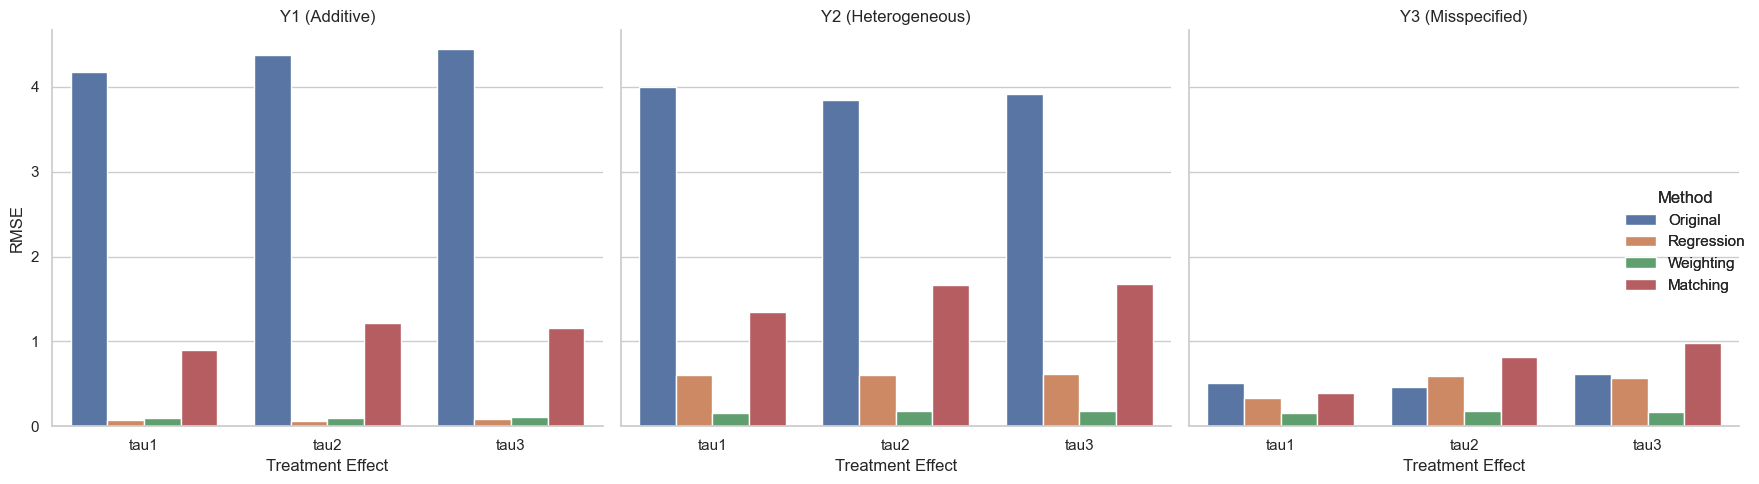

/var/folders/3_/4rpg118x5kl_s2bsjcfwflfc0000gn/T/ipykernel_19583/502685.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g_ess = sns.catplot(


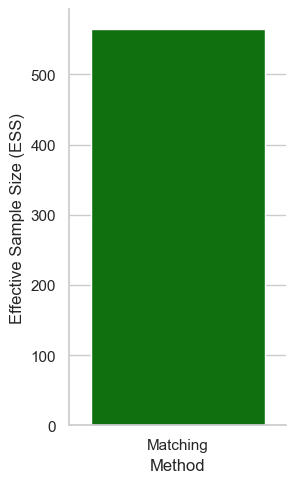

In [61]:
def plot_all_simulation_results(simulation_dict):
    sns.set(style="whitegrid")

    # === RMSE PLOT ===
    rmse_results = simulation_dict["rmse"]
    effects = ['tau1', 'tau2', 'tau3']
    methods_rmse = [
        "rmse_orig", "rmse_het_regression", "rmse_het_weighting", "rmse_het_matching"
    ]
    method_names_rmse = ["Original", "Regression", "Weighting", "Matching"]
    models = {
        "additive": "Y1 (Additive)",
        "heterogeneous": "Y2 (Heterogeneous)",
        "misspecified": "Y3 (Misspecified)"
    }

    data_rmse = []
    for model_type, res in rmse_results.items():
        for method_key, mname in zip(methods_rmse, method_names_rmse):
            rmse_values = res[method_key]  # shape (3,)
            for i, eff in enumerate(effects):
                data_rmse.append([models[model_type], eff, rmse_values[i], mname])

    df_rmse = pd.DataFrame(data_rmse, columns=["Outcome Model", "Effect", "RMSE", "Method"])

    g_rmse = sns.catplot(
        data=df_rmse,
        x="Effect",
        y="RMSE",
        hue="Method",
        col="Outcome Model",
        kind="bar",
        height=5,
        aspect=1
    )
    g_rmse.set_axis_labels("Treatment Effect", "RMSE")
    g_rmse.set_titles("{col_name}")
    g_rmse.set_xticklabels(rotation=0)
    g_rmse.add_legend(title="Method")
    plt.tight_layout()
    plt.show()

    # === ESS PLOT ===
    ess_results = simulation_dict["ess"]
    data_ess = [["ESS", "Matching", ess_results["mean_ess_het"]]]
    df_ess = pd.DataFrame(data_ess, columns=["Metric", "Method", "ESS"])

    g_ess = sns.catplot(
        data=df_ess,
        x="Method",
        y="ESS",
        kind="bar",
        height=5,
        aspect=0.6,
        palette=["green"]
    )
    g_ess.set_axis_labels("Method", "Effective Sample Size (ESS)")
    g_ess.set_titles("{col_name}")
    g_ess.add_legend()
    plt.tight_layout()
    plt.show()

plot_all_simulation_results(simulation_dict)

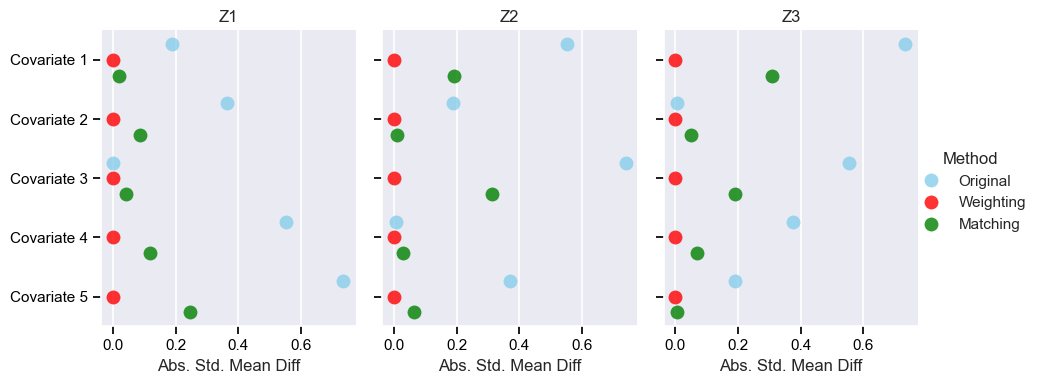

In [62]:
def plot_smd_by_treatment_group(smd_dict):
    """
    Plot SMDs faceted by treatment groups (Z combinations),
    showing original, weighting, and matching SMDs.
    Legend is outside and properly aligned without too much empty space.
    """
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from itertools import product

    covariate_names = [f"Covariate {i+1}" for i in range(smd_dict["orig"].shape[1])]
    methods = {
        "orig": "Original",
        "het_weighting": "Weighting",
        "het_matching": "Matching"
    }

    data = []
    for k in range(3):  # Z1, Z2, Z3
        for d in range(len(covariate_names)):
            for method_key, method_name in methods.items():
                smd_vals = smd_dict[method_key]  # shape (3, D)
                data.append({
                    "Treatment": f"Z{k+1}",
                    "Covariate": covariate_names[d],
                    "Method": method_name,
                    "SMD": abs(smd_vals[k, d])
                })

    df = pd.DataFrame(data)

    sns.set(style="whitegrid")
    sns.set_theme(
    style="ticks",  # Similar to the reference background
    rc={
        "axes.facecolor": "#EAEAF2",  # Light gray panel
        "axes.edgecolor": "white",
        "axes.grid": True,
        "grid.color": "white",
        "grid.linewidth": 1.2,
        "xtick.color": "black",
        "ytick.color": "black"
    }
    )
    g = sns.catplot(
        data=df,
        x="SMD",
        y="Covariate",
        hue="Method",
        col="Treatment",
        kind="strip",
        dodge=True,
        height=4,
        aspect=0.8,
        palette={"Original": "skyblue", "Weighting": "red", "Matching": "green"},
        alpha=0.8,
        s=100,
        jitter=False,
        legend_out=True
    )

    g.set_titles("{col_name}")
    g.set_axis_labels("Abs. Std. Mean Diff", "")

    # Reduce right spacing and pull legend a bit to the left
    g.fig.subplots_adjust(right=0.89)
   
plot_smd_by_treatment_group(simulation_dict["smd"])

### Apply to Data

In [37]:
def estimate_2way_interactions_weighted(Y, Z, w):
    """
    Computes two-factor interaction effects for all distinct pairs (k1, k2)
    in a K-factor design, using the general factorial-effects formula:

        tau_{k1,k2} = (1 / 2^(K-1)) * sum_{z in {+1, -1}^K} [z_{k1} * z_{k2} * Ybar(z)]
    """

    N, K = Z.shape
    # All 2^K possible assignments
    all_combos = np.array(list(product([-1, 1], repeat=K)))   # shape: (2^K, K)

    # Compute weighted means Ybar(z) for each possible z
    # We'll store them in a 1D array ybar_of_z, indexed by i in [0..2^K-1].
    ybar_of_z = np.full(len(all_combos), np.nan, dtype=float)

    for i, combo in enumerate(all_combos):
        # Identify units whose treatment vector == combo
        mask = np.all(Z == combo, axis=1)
        w_sub = w[mask]
        Y_sub = Y[mask]
        W = w_sub.sum()
        if W > 1e-15:  # to avoid dividing by zero
            ybar_of_z[i] = np.sum(w_sub * Y_sub) / W
    
    # For each pair (k1, k2), compute the two-factor interaction
    interaction_est = {}
    for k1 in range(K):
        for k2 in range(k1+1, K):
            # Define the contrast g_{k1,k2}(z) = z[k1]*z[k2]
            gvals = all_combos[:, k1] * all_combos[:, k2]

            # Weighted sum of gvals * ybar
            # We only include combos for which ybar_of_z is not NaN
            valid_mask = ~np.isnan(ybar_of_z)
            numerator = np.sum(gvals[valid_mask] * ybar_of_z[valid_mask])

            # Scale by 1 / 2^(K-1)
            val = (1.0 / (2 ** (K - 1))) * numerator
            interaction_est[(k1+1, k2+1)] = val

    return interaction_est


def fit_regression_with_interactions(Y, X, Z):
    N, D = X.shape
    K = Z.shape[1]
    
    # Construct design:
    # Start with intercept, covariates
    design_list = [np.ones(N)]
    for d_ in range(D):
        design_list.append(X[:, d_])
    
    # Add the 4 main effect columns of Z
    for k_ in range(K):
        design_list.append(Z[:, k_])
    
    # Add all pairwise interactions of Z
    # (If you want covariate interactions, add them too)
    for (k1, k2) in product(range(K), range(K)):
        if k1 < k2:
            design_list.append(Z[:, k1]*Z[:, k2])
    
    X_design = np.column_stack(design_list)
    
    # Fit linear regression
    model = sm.OLS(Y, X_design).fit()
    return model


def bootstrap_ci(effect_fn, Y, Z, w=None, n_boot=200, alpha=0.05):
    point_est = effect_fn(Y, Z, w)
    
    # collect bootstrap
    all_vals = {k:[] for k in point_est.keys()}
    N = len(Y)
    for b in range(n_boot):
        idx = np.random.choice(N, size=N, replace=True)
        Yb = Y[idx]
        Zb = Z[idx,:]
        wb = None if w is None else w[idx]
        tmp = effect_fn(Yb, Zb, wb)
        for k_ in tmp.keys():
            all_vals[k_].append(tmp[k_])
    
    out = {}
    for k_ in point_est.keys():
        arr = np.array(all_vals[k_])
        q_lower = np.nanpercentile(arr, 100*(alpha/2))
        q_upper = np.nanpercentile(arr, 100*(1 - alpha/2))
        out[k_] = {
            "estimate": point_est[k_],
            "ci_lower": q_lower,
            "ci_upper": q_upper
        }
    return out



In [38]:
if __name__ == "__main__":
    data = pd.read_csv("/Users/zengyx/Desktop/voc_hr.csv")

    # Convert treatment indicators from 0->-1, 1->+1
    data["benzene"] = data["benzene"].map({0: -1, 1: +1})
    data["dichlorobenzene"] = data["dichlorobenzene"].map({0: -1, 1: +1})
    data["ethylbenzene"] = data["ethylbenzene"].map({0: -1, 1: +1})
    data["mtbe"] = data["mtbe"].map({0: -1, 1: +1})

    bool_cols = ["black", "hispanic", "alcohol", "smoking", "hypertension"]
    for col in bool_cols:
        data[col] = data[col].map({False: 0, True: 1})


    # Show columns for verification
    print("Columns:", data.columns.tolist())
    print(data.head())
    

    # Build numpy arrays
    treatment_cols = ["benzene", "dichlorobenzene", "ethylbenzene","mtbe"]
    #covariate_cols = ["bmi", "age", "black", "hispanic", "povertyr","alcohol", "smoking", "hypertension"]
    covariate_cols = ["age", "black", "povertyr","alcohol", "smoking", "hypertension"]
    outcome_col = "heartrate"

    Z = data[treatment_cols].values      # shape (N,4)
    X = data[covariate_cols].values     # shape (N,8)  (example)
    Y = data[outcome_col].values        # shape (N,)
    N, D = X.shape
    K = Z.shape[1]  # should be 4
    Z = Z.astype(float)   # or int, but typically float
    X = X.astype(float)
    Y = Y.astype(float)

    # --- Step A: Read data ---

    # --- Step B: Solve weighting and matching ---
    w_continuous = solve_weights_heterogeneous(X, Z)
    w_binary = solve_matching_heterogeneous(X, Z, lambda_penalty=100000.0)
    
    # --- Step C: Fit regression with interactions (linear model) ---
    reg_model = fit_regression_with_interactions(Y, X, Z)
    # Pull out coefficients for main effects and 2way interactions 
    # (you need to carefully map each coefficient to the correct contrast).
    # For demonstration, we'll just use reg_model.get_prediction() approach to get factorial effects:
    
    def regression_factorial_effects(model, X, Z):
        """
        Example approach: 
          - For each (z1,z2,z3,z4) in {+1, -1}^4, predict Yhat 
          - Then compute the usual factorial contrasts
        """
        combos = np.array(list(product([-1,1], repeat=4)))
        # We set covariates = average of X for all predictions,
        # then vary Z as combos.
        X_mean = np.mean(X, axis=0)
        Ncomb = combos.shape[0]
        
        # Build design for each combination
        # same design_list approach as in fit_regression_with_interactions
        design_list = []
        for c in combos:
            row = [1.0]  # intercept
            row.extend(X_mean)  # mean of each covariate
            row.extend(c)       # the four Z values
            # 6 pairwise interactions
            pair_ints = []
            for (k1,k2) in product(range(4), range(4)):
                if k1 < k2:
                    pair_ints.append(c[k1]*c[k2])
            row.extend(pair_ints)
            design_list.append(row)
        
        X_design = np.array(design_list)
        Yhat = model.predict(X_design)  # shape (16,)
        
        # main effects
        main_effects = {}
        for k_ in range(4):
            # define a function to get the difference between + and -
            # for factor k_, marginalizing over other 3 factors
            # i.e., average Yhat over combos with z_k=+1 minus combos with z_k=-1
            sum_plus = 0.0
            sum_minus= 0.0
            count_plus = 0
            count_minus= 0
            for i,z_ in enumerate(combos):
                if z_[k_] == +1:
                    sum_plus  += Yhat[i]
                    count_plus += 1
                else:
                    sum_minus += Yhat[i]
                    count_minus+=1
            main_effects[k_+1] = (sum_plus/count_plus) - (sum_minus/count_minus)
        
        # 2-way interactions
        inter_effects = {}
        for (k1,k2) in product(range(4), range(4)):
            if k1 < k2:
                # standard formula for 2-factor interaction
                # 1/4 * [Y(++), Y(+-), Y(-+), Y(--)]
                # we find those combos
                Ypp = None; Ypm=None; Ymp=None; Ymm=None
                for i,z_ in enumerate(combos):
                    if (z_[k1]==+1 and z_[k2]==+1): Ypp = Yhat[i]
                    if (z_[k1]==+1 and z_[k2]==-1): Ypm = Yhat[i]
                    if (z_[k1]==-1 and z_[k2]==+1): Ymp = Yhat[i]
                    if (z_[k1]==-1 and z_[k2]==-1): Ymm = Yhat[i]
                inter_val = 0.25*(Ypp - Ypm - Ymp + Ymm)
                inter_effects[(k1+1,k2+1)] = inter_val
        
        return main_effects, inter_effects

    # point estimates
    reg_main, reg_twoway = regression_factorial_effects(reg_model, X, Z)
    
    # approximate regression standard errors for those factorial contrasts
    # For brevity, one might do Delta method or direct predictions with covariance.
    # We'll skip that detail or do a quick normal-approx approach:
    # (Here we illustrate a simplified bootstrap approach for CIs on the regression fits.)
    
    # Weighted
    if w_continuous is not None:
        w_main = estimate_main_effects_weighted(Y, Z, w_continuous)
        w_int  = estimate_2way_interactions_weighted(Y, Z, w_continuous)
        # for 95% CI, do boot
        w_main_ci = bootstrap_ci(estimate_main_effects_weighted, Y, Z, w=w_continuous)
        w_int_ci  = bootstrap_ci(estimate_2way_interactions_weighted, Y, Z, w=w_continuous)
    else:
        w_main_ci = {}
        w_int_ci  = {}
    
    # Matched
    if w_binary is not None:
        w_main_m = estimate_main_effects_matched(Y, Z, w_binary)
        w_int_m  = estimate_2way_interactions_weighted(Y, Z, w_binary)
        w_main_m_ci = bootstrap_ci(estimate_main_effects_matched, Y, Z, w=w_binary)
        w_int_m_ci  = bootstrap_ci(estimate_2way_interactions_weighted, Y, Z, w=w_binary)
    else:
        w_main_m_ci = {}
        w_int_m_ci  = {}

    # Regression 
    # (already have reg_main, reg_twoway).  For approximate CIs, do a parametric bootstrap or the 
    # built-in "get_prediction" trick with covariance.  Below is a minimal hack:
    reg_main_ci, reg_int_ci = {}, {}
    # We'll do a small parametric bootstrap:
    def reg_factorial_boot(Y, X, Z, n_boot=200):
        N = len(Y)
        main_vals = []
        int_vals = []
        for _ in range(n_boot):
            # param. bootstrap: sample residuals
            residuals = reg_model.resid
            res_samp  = np.random.choice(residuals, size=N, replace=True)
            Yb = reg_model.fittedvalues + res_samp
            mb = fit_regression_with_interactions(Yb, X, Z)
            mb_main, mb_int = regression_factorial_effects(mb, X, Z)
            main_vals.append(mb_main)
            int_vals.append(mb_int)
        return main_vals, int_vals
    
    main_bs, int_bs = reg_factorial_boot(Y, X, Z, n_boot=200)
    # Convert lists-of-dicts => dict-of-lists
    main_dictlist = {}
    for k_ in reg_main.keys():
        main_dictlist[k_] = [m[k_] for m in main_bs]
    inter_dictlist = {}
    for k_ in reg_twoway.keys():
        inter_dictlist[k_] = [m[k_] for m in int_bs]
    
    for k_ in reg_main.keys():
        arr = np.array(main_dictlist[k_])
        lo = np.percentile(arr, 2.5)
        hi = np.percentile(arr, 97.5)
        reg_main_ci[k_] = {
            "estimate": reg_main[k_],
            "ci_lower": lo,
            "ci_upper": hi
        }
    for k_ in reg_twoway.keys():
        arr = np.array(inter_dictlist[k_])
        lo = np.percentile(arr, 2.5)
        hi = np.percentile(arr, 97.5)
        reg_int_ci[k_] = {
            "estimate": reg_twoway[k_],
            "ci_lower": lo,
            "ci_upper": hi
        }
    
    # Finally, assemble a table of (Estimate, 95% CI) for each effect, 
    # across Weighting, Matching, Regression. 
    # For brevity, we show just main effects here; you can do the same for interactions.

    print("\n===== Main Effects =====")
    print("Effect | Weighting (95% CI) | Matching (95% CI) | Regression (95% CI)")
    for k_ in [1,2,3,4]:  # 4 exposures
        # Weighting
        if k_ in w_main_ci:
            wE = w_main_ci[k_]["estimate"]
            wL = w_main_ci[k_]["ci_lower"]
            wH = w_main_ci[k_]["ci_upper"]
            w_str = f"{wE:.3f} [{wL:.3f}, {wH:.3f}]"
        else:
            w_str = "NA"
        
        # Matching
        if k_ in w_main_m_ci:
            mE = w_main_m_ci[k_]["estimate"]
            mL = w_main_m_ci[k_]["ci_lower"]
            mH = w_main_m_ci[k_]["ci_upper"]
            m_str = f"{mE:.3f} [{mL:.3f}, {mH:.3f}]"
        else:
            m_str = "NA"
        
        # Regression
        if k_ in reg_main_ci:
            rE = reg_main_ci[k_]["estimate"]
            rL = reg_main_ci[k_]["ci_lower"]
            rH = reg_main_ci[k_]["ci_upper"]
            r_str = f"{rE:.3f} [{rL:.3f}, {rH:.3f}]"
        else:
            r_str = "NA"
        
        print(f"VOC{k_}   | {w_str}  | {m_str}  | {r_str}")
    
    print("\n===== 2-way Interactions =====")
    print("Effect (k1,k2) | Weighting (95% CI) | Matching (95% CI) | Regression (95% CI)")
    # we expect pairs (1,2),(1,3),(1,4),(2,3),(2,4),(3,4)
    for (k1,k2) in sorted(reg_int_ci.keys()):
        # Weighting
        if (k1,k2) in w_int_ci:
            wE = w_int_ci[(k1,k2)]["estimate"]
            wL = w_int_ci[(k1,k2)]["ci_lower"]
            wH = w_int_ci[(k1,k2)]["ci_upper"]
            w_str = f"{wE:.3f} [{wL:.3f}, {wH:.3f}]"
        else:
            w_str = "NA"
        
        # Matching
        if (k1,k2) in w_int_m_ci:
            mE = w_int_m_ci[(k1,k2)]["estimate"]
            mL = w_int_m_ci[(k1,k2)]["ci_lower"]
            mH = w_int_m_ci[(k1,k2)]["ci_upper"]
            m_str = f"{mE:.3f} [{mL:.3f}, {mH:.3f}]"
        else:
            m_str = "NA"
        
        # Regression
        if (k1,k2) in reg_int_ci:
            rE = reg_int_ci[(k1,k2)]["estimate"]
            rL = reg_int_ci[(k1,k2)]["ci_lower"]
            rH = reg_int_ci[(k1,k2)]["ci_upper"]
            r_str = f"{rE:.3f} [{rL:.3f}, {rH:.3f}]"
        else:
            r_str = "NA"
        
        print(f"({k1},{k2})           | {w_str}  | {m_str}  | {r_str}")


Columns: ['Unnamed: 0', 'benzene', 'dichlorobenzene', 'ethylbenzene', 'mtbe', 'bmi', 'heartrate', 'age', 'black', 'hispanic', 'povertyr', 'alcohol', 'smoking', 'hypertension']
   Unnamed: 0  benzene  dichlorobenzene  ethylbenzene  mtbe   bmi  heartrate  \
0          12        1                1             1    -1  33.3         80   
1          29       -1               -1            -1    -1  22.4         84   
2          58        1                1             1    -1  45.4         94   
3          69       -1               -1            -1    -1  28.6         78   
4          71       -1                1            -1    -1  33.2         64   

   age  black  hispanic  povertyr  alcohol  smoking  hypertension  
0   43      1         0      2.02        1        1             0  
1   30      0         0      3.04        1        0             0  
2   38      1         0      4.05        1        1             1  
3   31      0         0      1.31        1        0             1  
4  

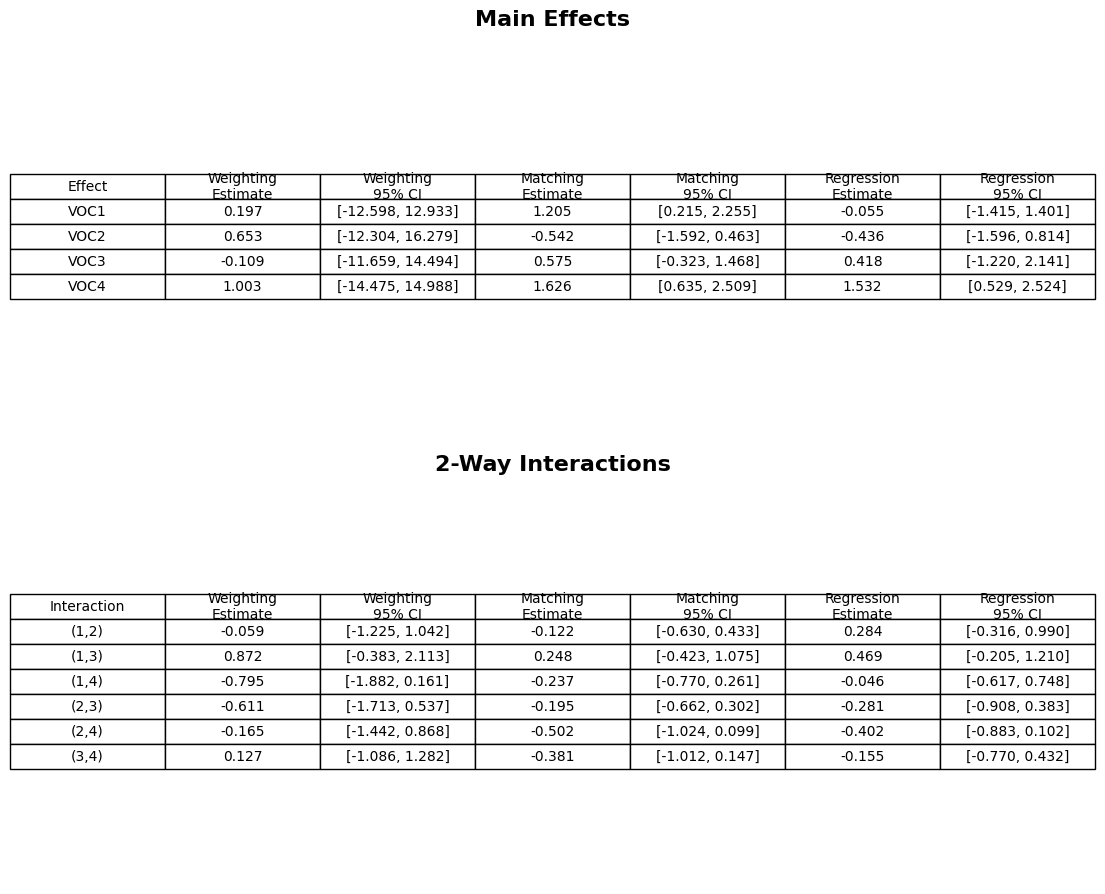

In [ ]:
main_rows = []
for k_ in [1, 2, 3, 4]:
    effect = f"VOC{k_}"
    
    # Weighting: Separate estimate and CI
    if k_ in w_main_ci:
        w_est = f"{w_main_ci[k_]['estimate']:.3f}"
        w_ci  = f"[{w_main_ci[k_]['ci_lower']:.3f}, {w_main_ci[k_]['ci_upper']:.3f}]"
    else:
        w_est = "NA"
        w_ci  = "NA"
    
    # Matching: Separate estimate and CI
    if k_ in w_main_m_ci:
        m_est = f"{w_main_m_ci[k_]['estimate']:.3f}"
        m_ci  = f"[{w_main_m_ci[k_]['ci_lower']:.3f}, {w_main_m_ci[k_]['ci_upper']:.3f}]"
    else:
        m_est = "NA"
        m_ci  = "NA"
    
    # Regression: Separate estimate and CI
    if k_ in reg_main_ci:
        r_est = f"{reg_main_ci[k_]['estimate']:.3f}"
        r_ci  = f"[{reg_main_ci[k_]['ci_lower']:.3f}, {reg_main_ci[k_]['ci_upper']:.3f}]"
    else:
        r_est = "NA"
        r_ci  = "NA"
    
    main_rows.append([effect, w_est, w_ci, m_est, m_ci, r_est, r_ci])

main_df = pd.DataFrame(main_rows,
                       columns=["Effect",
                                "Weighting Estimate", "Weighting 95% CI",
                                "Matching Estimate", "Matching 95% CI",
                                "Regression Estimate", "Regression 95% CI"])

interact_rows = []
# Sorting keys for consistency. Each key is assumed to be a tuple (k1, k2).
for (k1, k2) in sorted(reg_int_ci.keys()):
    effect = f"({k1},{k2})"
    
    # Weighting
    if (k1, k2) in w_int_ci:
        w_est = f"{w_int_ci[(k1, k2)]['estimate']:.3f}"
        w_ci  = f"[{w_int_ci[(k1, k2)]['ci_lower']:.3f}, {w_int_ci[(k1, k2)]['ci_upper']:.3f}]"
    else:
        w_est = "NA"
        w_ci  = "NA"
    
    # Matching
    if (k1, k2) in w_int_m_ci:
        m_est = f"{w_int_m_ci[(k1, k2)]['estimate']:.3f}"
        m_ci  = f"[{w_int_m_ci[(k1, k2)]['ci_lower']:.3f}, {w_int_m_ci[(k1, k2)]['ci_upper']:.3f}]"
    else:
        m_est = "NA"
        m_ci  = "NA"
    
    # Regression
    if (k1, k2) in reg_int_ci:
        r_est = f"{reg_int_ci[(k1, k2)]['estimate']:.3f}"
        r_ci  = f"[{reg_int_ci[(k1, k2)]['ci_lower']:.3f}, {reg_int_ci[(k1, k2)]['ci_upper']:.3f}]"
    else:
        r_est = "NA"
        r_ci  = "NA"
    
    interact_rows.append([effect, w_est, w_ci, m_est, m_ci, r_est, r_ci])

interact_df = pd.DataFrame(interact_rows,
                           columns=["Interaction",
                                    "Weighting Estimate", "Weighting 95% CI",
                                    "Matching Estimate", "Matching 95% CI",
                                    "Regression Estimate", "Regression 95% CI"])

top_headers_main = ["", "Weighting", "Weighting", "Matching", "Matching", "Regression", "Regression"]
bottom_headers_main = ["Effect", "Estimate", "95% CI", "Estimate", "95% CI", "Estimate", "95% CI"]

multi_cols_main = pd.MultiIndex.from_arrays([top_headers_main, bottom_headers_main])
main_df.columns = multi_cols_main

top_headers_int = ["", "Weighting", "Weighting", "Matching", "Matching", "Regression", "Regression"]
bottom_headers_int = ["Interaction", "Estimate", "95% CI", "Estimate", "95% CI", "Estimate", "95% CI"]

multi_cols_int = pd.MultiIndex.from_arrays([top_headers_int, bottom_headers_int])
interact_df.columns = multi_cols_int

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
fig.patch.set_facecolor('white')
# Reduce vertical spacing by setting hspace to a small value
plt.subplots_adjust(top=0.90, bottom=0.05, hspace=0.1)

# For the table display we need to flatten the multi-index into a single string per column;
# here we join the top and bottom header using a newline.
def flatten_multiindex(mi):
    return [f"{top}\n{bot}" if top != "" else bot for top, bot in mi]

# Prepare display labels for main effects
disp_labels_main = flatten_multiindex(main_df.columns)
# Plot Main Effects Table
ax1.axis('tight')
ax1.axis('off')
table_main = ax1.table(cellText=main_df.values,
                       colLabels=disp_labels_main,
                       cellLoc='center',
                       loc='center')
table_main.auto_set_font_size(False)
table_main.set_fontsize(10)
table_main.scale(1, 1.5)
ax1.set_title("Main Effects", fontsize=16, fontweight="bold")

# Prepare display labels for 2-way interactions
disp_labels_int = flatten_multiindex(interact_df.columns)
# Plot Two-Way Interactions Table
ax2.axis('tight')
ax2.axis('off')
table_int = ax2.table(cellText=interact_df.values,
                      colLabels=disp_labels_int,
                      cellLoc='center',
                      loc='center')
table_int.auto_set_font_size(False)
table_int.set_fontsize(10)
table_int.scale(1, 1.5)
ax2.set_title("2-Way Interactions", fontsize=16, fontweight="bold")

plt.show()


## Setup 2

### Approach:


I stratified the selected samples into several groups (strata) and within each stratum, the distribution of covariates is balanced across treatment levels. The method forces that, within each stratum, the means and interactions of the covariates for units receiving “+1” and “–1” treatments to be very similar (within a specified tolerance). 

I start with a dataset of N selected units, each with 5 covariates (stored in X) and a set of 3 treatment indicators (stored in Z, with entries either +1 or –1). The goal is to assign every unit to one of a fixed number of strata (S strata) such that within each stratum the covariate distributions between the treatment groups (for each factor and for interactions like the ones in the balancing weight method) of +1 and -1 are similar.

##### Decision Variables:
Let:
- $N$: Number of units
- $D$: Number of covariates
- $K$: Number of treatment factors
- $S$: Number of strata (fixed)


For each unit $i$ = 1, $\dots$, N and stratum $s$ = 1, $\dots$, S, define:
$$
S_{i,s} \in \{0, 1\}
$$
- $S_{i,s}$ = 1 if unit $i$ is assigned to stratum $s$.
- Constraint: Each unit is assigned to exactly one stratum:
$
\sum_{s=1}^{S} S_{i,s} = 1 \quad \forall i
$


Slack variables allow relaxed constraints:
- For each balancing constraint, introduce:
$
\text{sp}_{\text{plus}}, \text{sm}_{\text{plus}}, \text{sp}_{\text{minus}}, \text{sm}_{\text{minus}} \geq 0
$


##### Balancing Constraints:

Balance is required within each stratum for covariates and for interactions.

Main Effects: For each stratum $s$, treatment $k$, and covariate $d$:

Let:
- $ A^+_{i,k} = \mathbb{1}\{Z_{i,k} = +1\} $
- $ A^-_{i,k} = 1 - A^+_{i,k}$

The balance constraints (with slack):
$$
\sum_{i} S_{i,s} A^+_{i,k} X_{i,d} - \sum_{i} S_{i,s} A^-_{i,k} X_{i,d} \leq \text{sp}_{\text{plus}}
$$

and similarly for the minus group.

Interaction Effects: Let $J \subset \{1, \dots, K\} $ be a subset of treatment factors. Define interaction:
$
Z^{(J)}_i = \prod_{j \in J} Z_{i,j}
$

Let:
- $ Z_{\text{all}} \in \{-1,1\}^{2^K \times K} $: All possible treatment vectors

Then the constraint for interactions becomes:
$$
\sum_{i=1}^N S_{i,s} A^+_{i,k} Z^{(J)}_i - \sum_{i=1}^N S_{i,s} A^-_{i,k} Z^{(J)}_i \leq \text{sp}_{\text{inter}}
$$

##### Objective Function:

I set the goal to minimize imbalance, represented by the sum of slack variables.

Heterogeneous Objective:

Uses a penalty parameter $\lambda $ to scale imbalance,
$$
\min \lambda \cdot \sum \text{all slack variables}
$$

This encourages tighter balance but allows flexibility when necessary.


##### Solution and Output:

- A MILP is solved using Gurobi.
- The solution yields a stratum assignment $ S_{i,s} \in \{0,1\} $, which is converted into a single stratum label for each unit.

Right now the smd of each strata is very high because the tolerance and penalty term is very big. If I make the tolerance smaller, I get all infeasible outputs.

In [60]:
D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

def solve_strata_hetero(X, Z, num_strata=5, tol=0.1, lambda_penalty=100.0):
    
    model = gp.Model("StrataHeteroAbsDiff_slack")
    model.setParam('OutputFlag', 0)
    
    N, D = X.shape
    K = Z.shape[1]
    
    # === 1. Strata assignment variables ===
    # S[i, s] = 1 if unit i is assigned to stratum s, 0 otherwise.
    S = model.addVars(N, num_strata, vtype=GRB.BINARY, name="S")
    
    # Define stratum sizes.
    stratum_size = model.addVars(num_strata, lb=0.0, name="stratum_size")
    
    # Each unit must be assigned to exactly one stratum.
    for i in range(N):
        model.addConstr(gp.quicksum(S[i, s] for s in range(num_strata)) == 1,
                        name=f"assign_unit_{i}")
    
    # Define the size of each stratum.
    for s in range(num_strata):
        model.addConstr(stratum_size[s] == gp.quicksum(S[i, s] for i in range(N)),
                        name=f"size_def_{s}")
    
    # === 2. Prepare the balancing quantities ===
    # Build basis functions: we take an intercept and each covariate.
    basis_vals = [np.ones(N)]
    for d in range(D):
        basis_vals.append(X[:, d])
    n_s = len(basis_vals)  # number of basis functions
    
    # Define a list for main effects: empty tuple (for intercept) plus each factor separately.
    J_list = [()] + [(k,) for k in range(K)]
    n_J = len(J_list)
    
    # Precompute Qvals: for each unit i, each basis function index s_idx, and each grouping j_idx,
    #   Qvals[i, s_idx, j_idx] = (basis_vals[s_idx][i]) * (product over j in grouping of Z[i,j])
    Qvals = np.zeros((N, n_s, n_J))
    for j_idx, J_ in enumerate(J_list):
        if len(J_) == 0:
            Zp = np.ones(N)
        else:
            # Multiply the relevant columns in Z.
            Zp = np.prod(Z[:, list(J_)], axis=1)
        for s_idx in range(n_s):
            Qvals[:, s_idx, j_idx] = basis_vals[s_idx] * Zp
    
    # Build treatment indicator matrices.
    # Aplus[i, k] = 1 if Z[i, k] is +1, and Aminus[i, k] = 1 if Z[i, k] is -1.
    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus  # since Z entries are +1 or -1.
    
    # === 3. Add balance constraints per stratum ===
    # For each treatment factor (k), basis (s_idx), and main-effect grouping (j_idx)
    # and for each stratum s, we want the difference between the sums of
    # Qvals for units with treatment +1 and -1 to be near zero.
    # We express this by introducing one slack variable per moment which bounds 
    # the absolute imbalance:
    #
    #      - t_{k,s_idx,j_idx,s}  <=  sum_{i in stratum s} [ (Aplus[i,k]-Aminus[i,k])*Qvals[i,s_idx,j_idx] ]  <= t_{k,s_idx,j_idx,s} .
    #
    # We then penalize the sum of all t's in the objective.
    
    slack_vars = []
    for k in range(K):
        for s_idx in range(n_s):
            for j_idx in range(n_J):
                for s in range(num_strata):
                    t_var = model.addVar(lb=0.0, name=f"t_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    slack_vars.append(t_var)
                    lhs_diff = gp.quicksum(S[i, s] * (Aplus[i, k] - Aminus[i, k]) * Qvals[i, s_idx, j_idx] for i in range(N))
                    model.addConstr(lhs_diff <= tol + t_var, name=f"cons1_k{k}_s{s_idx}_j{j_idx}_s{s}")
                    model.addConstr(lhs_diff >= -tol -t_var, name=f"cons2_k{k}_s{s_idx}_j{j_idx}_s{s}")
    
    # === 4. Objective: minimize the total slack (imbalance) ===
    obj = lambda_penalty * gp.quicksum(slack_vars)
    model.setObjective(obj, GRB.MINIMIZE)
    
    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Infeasible or no optimal solution found.")
        return None
    
    # Retrieve the stratum assignment for each unit.
    strata_assign = np.zeros(N, dtype=int)
    for i in range(N):
        for s in range(num_strata):
            if S[i, s].X > 0.5:
                strata_assign[i] = s
                break
    
    return strata_assign


def run_simulation_matching_strata(n_sims=50, N=200, lambda_penalty=100.0, tol= 0.1, num_strata=5):
    simulation_results = []

    for sim in range(n_sims):
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)  # 'Sigma' from your global context
        Z_ = generate_treatments(Xraw)   # your function that returns +/-1 for each factor

        #    (Additive & Heterogeneous)
        matchH = solve_matching_heterogeneous(Xraw, Z_, lambda_penalty=0.02)

        if matchH is not None:
            selected_indices_H = np.flatnonzero(matchH > 0.5)
            X_selected_H = Xraw[selected_indices_H, :]
            Z_selected_H = Z_[selected_indices_H, :]
        else:
            selected_indices_H = np.array([], dtype=int)

        #    (Additive & Heterogeneous w/ slack)
        # These functions assign every unit to exactly 1 stratum if feasible.
        assignment_H = solve_strata_hetero(X_selected_H, Z_selected_H, num_strata=num_strata,tol=tol,lambda_penalty=lambda_penalty)
        # Calculate SMDs within each stratum for strata-based solutions
        sim_result = {
            "X": Xraw,
            "Z": Z_,
            # weighting-based               
            "matchH": matchH,                   
            "selected_indices_H": selected_indices_H,
            # strata-based
            "clusters_H": assignment_H,
        }
        simulation_results.append(sim_result)

    return simulation_results


##### Output with n_sims = 100, N = 200, tol_add = 0.25, tol_het = 0.3, tol_add_strata = 0.1, tol_het_strata = 10, lambda_penalty = 1 and num_strata = 2

In [ ]:
def main():
    # Simulation parameters
    n_sims = 100
    N = 10000
    tol = 10
    lambda_penalty = 1
    num_strata = 2

    sim_results = run_simulation_matching_strata(n_sims=n_sims,N=N,lambda_penalty=lambda_penalty,tol=tol,num_strata=num_strata)

    # Collect info about feasibility and summary statistics.
    feasible_matchH = 0
    total_size_matchH = []

    feasible_strataH = 0
    num_strata_usedH = []

    for sim_idx, out in enumerate(sim_results):
        # Weighting-based matching info.
        matchH = out["matchH"]
        idxH   = out["selected_indices_H"]

        if matchH is not None:
            feasible_matchH += 1
            total_size_matchH.append(len(idxH))
        else:
            total_size_matchH.append(0)

        # Strata-based matching info.
        clusters_H = out["clusters_H"]

        if clusters_H is not None and len(clusters_H) == N:
            feasible_strataH += 1
            used_strata_listH = np.unique(clusters_H)
            num_strata_usedH.append(len(used_strata_listH))
        else:
            num_strata_usedH.append(0)

        # Print mapping of unit indices to strata assignments.
        print(f"\n=== Simulation {sim_idx+1} ===")
        if clusters_H is not None and len(clusters_H) == N:
            print("Strata-based Heterogeneous Assignment:")
            strata_map_H = {s: np.where(clusters_H == s)[0].tolist() for s in np.unique(clusters_H)}
            for s, units in strata_map_H.items():
                print(f"  Stratum {s}: Units {units}")
        else:
            print("Strata-based Heterogeneous Assignment: Infeasible or not available.")

    # Print summary statistics.
    print("\n==== Simulation Summary ====")
    print(f"Number of simulations: {n_sims}")
    print("---- Weighting-based Heterogeneous Matching ----")
    print(f"Feasible in {feasible_matchH}/{n_sims} sims")
    print(f"Average matched sample size: {np.mean(total_size_matchH):.2f}")
    print("---- Strata-based Heterogeneous Approach ----")
    print(f"Feasible in {feasible_strataH}/{n_sims} sims")
    print(f"Average # of strata actually used: {np.mean(num_strata_usedH):.2f}")

if __name__ == "__main__":
    main()

Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 144 rows, 10288 columns and 720288 nonzeros
Model fingerprint: 0xb19b8d88
Variable types: 288 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [7e-05, 5e+00]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+01, 1e+04]
Found heuristic solution: objective -3088.804876
Presolve removed 62 rows and 5892 columns
Presolve time: 0.53s
Presolved: 82 rows, 4396 columns, 174693 nonzeros
Variable types: 164 continuous, 4232 integer (4232 binary)

Root relaxation: objective 6.279676e+03, 83 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent   